In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -1
pars['a01'] = 1
pars['a10'] = 0
pars['a11'] = -1
pars['gamma0'] = 1
pars['gamma1'] = 1

pars['kb'] = 1.38*10**-2

pars['T0'] = 300
pars['T1'] = 300
pars['noise0'] = 2*pars['gamma0']*pars['kb']*pars['T0']
pars['noise1'] = 2*pars['gamma1']*pars['kb']*pars['T1']

pars['n_realizations'] = 10
pars['delta_t'] = 0.01

In [3]:
(pars['a00']*pars['a11']) - (pars['a01']*pars['a10'])

1

In [4]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 + (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] + \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0'])/((pars['gamma0'])**2))*s1
                 
        x2_new = x2 + (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] + \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1'])/((pars['gamma1'])**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [5]:
def euler_n_traj(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t']+1) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    x_traj_list = []
    y_traj_list = []
    for i in tqdm(range(pars['n_realizations'])):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

In [6]:
def plotter_traj(x_traj_list, y_traj_list):
    fig, ax = plt.subplots(1, 3, figsize=(15,3))

    for x in x_traj_list:
        ax[0].plot(time, x)
    for y in y_traj_list:
        ax[1].plot(time, y)
    for x,y in zip(x_traj_list, y_traj_list):
        ax[2].plot(x,y)

    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')

    ax[1].set_xlabel('t')
    ax[1].set_ylabel('y')

    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

In [7]:
#plot trajectories with t = 10s
pars['n_realizations'] = 50
length_plot = 100
x_traj_list, y_traj_list, time = euler_n_traj(length_plot, pars)

100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


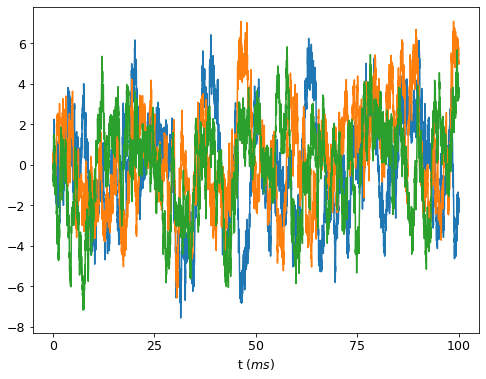

In [8]:
#Plot a sample trajectory
fig = plt.figure(figsize=(8,6))
plt.plot(time, x_traj_list[0])
plt.plot(time, x_traj_list[1])
plt.plot(time, x_traj_list[2])
plt.xlabel('t ($ms$)', fontsize=12.5)
# plt.ylabel('x ($nm$)', fontsize=12.5)
plt.xticks(np.linspace(0, length_plot, 5), fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.savefig('sample_traj_results.png', dpi=300)
plt.show()

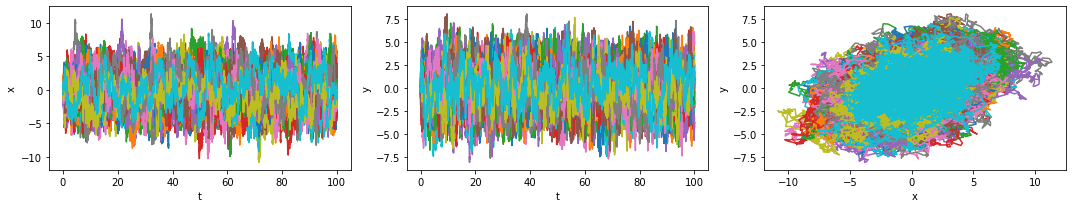

In [9]:
plotter_traj(x_traj_list, y_traj_list)

In [10]:
len(x_traj_list[0])

10001

In [11]:
relax_time = int(abs(pars['gamma1']/pars['a11']))
traj_wout_relaxation_time = []
for traj in x_traj_list:
    final_traj = traj[relax_time::]
    traj_wout_relaxation_time.append(final_traj)

In [12]:
len(np.arange(1, len(traj_wout_relaxation_time[0]),10))

1000

In [13]:
def autocorr(x):
    tau = np.arange(1, len(traj_wout_relaxation_time[0]),10)
    
    corr_list = []
    for t in tau:
        xtau = np.roll(x, -t)
        
        product_list = []
        for x_value, xtau_value in zip(x, xtau):
            product = x_value*xtau_value
            product_list.append(product)
            
            
        corr = np.array(product_list[:-t]).mean()
        corr_list.append(corr)
    return corr_list

In [14]:
def ave_autocorr_traj(trajectory):
    autocorr_list = []
    for traj in tqdm(trajectory):
        autocorr_traj = autocorr(traj)
        autocorr_list.append(autocorr_traj)
        
    matrix = np.array((autocorr_list))
    mean_per_column = matrix.mean(axis=0)
    
    return mean_per_column

In [15]:
%%time
xtraj = ave_autocorr_traj(traj_wout_relaxation_time)

100%|██████████| 50/50 [01:57<00:00,  2.34s/it]

Wall time: 1min 57s


In [16]:
normalization = np.mean((np.array(traj_wout_relaxation_time))*(np.array(traj_wout_relaxation_time)))
final_c = xtraj/normalization

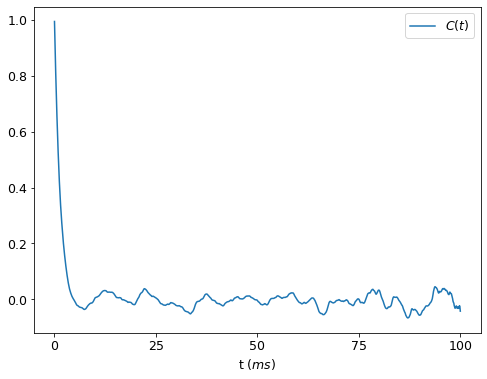

In [17]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.linspace(0,length_plot,len(final_c)), final_c, label='$C(t)$')
# plt.axhline(0, color='black', ls='dashed')
plt.xlabel('t ($ms$)', fontsize=12.5)
# plt.ylabel('$C$ ($nm^2$)', fontsize=12.5)
plt.xticks(np.linspace(0, length_plot, 5), fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.legend(prop={'size': 12.5})
# plt.savefig('autocorrelation_sensor.png', dpi=300)
plt.show()